In [46]:
!pip install emnist

In [47]:
import numpy as np
from keras.layers import *
from keras.models import Model, load_model
from keras import backend as K
from keras import losses
from keras.optimizers import SGD
import imageio,os
from PIL import Image
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [48]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [49]:
batchSize = 100
latentDim = 20
epochs = 200
imgShape = 28
filters = 16
intermediateDim = 256
learningRate = 0.005
momentum = 0.5
#dataset = 'mnist'
dataset = 'fashion'

In [50]:
if dataset == 'mnist':
  classNum = 10
  from keras.datasets import mnist
  (trainImage, trainLabel), (testImage, testLabel) = mnist.load_data()
elif dataset == 'fashion':
  classNum = 10
  from keras.datasets import fashion_mnist as mnist
  (trainImage, trainLabel), (testImage, testLabel) = mnist.load_data()

In [51]:
trainImage = trainImage.astype('float32') / 255.
testImage = testImage.astype('float32') / 255.
trainImage = trainImage.reshape((-1, imgShape, imgShape, 1))
testImage = testImage.reshape((-1, imgShape, imgShape, 1))

In [52]:
# Building model
x = Input(shape=(imgShape, imgShape, 1))
h = x

# CNN
h = Conv2D(filters=filters, kernel_size=3, strides=2, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(filters=filters*2, kernel_size=3, strides=2, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(filters=filters*2, kernel_size=3, strides=1, padding='same')(h)
h = LeakyReLU(0.2)(h)

hShape = K.int_shape(h)[1:]
h = Flatten()(h)
mean = Dense(latentDim)(h) # Mean of p(z|x)
logVariance = Dense(latentDim)(h) # Variance of p(z|x)

encoder = Model(x, mean)

In [53]:
z = Input(shape=(latentDim,))
h = z
h = Dense(np.prod(hShape))(h)
h = Reshape(hShape)(h)

h = Conv2DTranspose(filters=filters*2, kernel_size=3, strides=1, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2DTranspose(filters=filters*2, kernel_size=3, strides=2, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2DTranspose(filters=filters, kernel_size=3, strides=1, padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2DTranspose(filters=filters, kernel_size=3, strides=2, padding='same')(h)
h = LeakyReLU(0.2)(h)

xReconstruction = Conv2DTranspose(filters=1, kernel_size=3, activation='sigmoid', padding='same')(h)

decoder = Model(z, xReconstruction)

In [54]:
z = Input(shape=(latentDim,))
y = Dense(intermediateDim, activation='relu')(z)
y = Dense(classNum, activation='softmax')(y)

classifier = Model(z, y) # Latent variable classifier

In [55]:
def sampling(args):
    mean, logVariance = args
    epsilon = K.random_normal(shape=(K.shape(mean)[0], latentDim))
    return mean + K.exp(logVariance / 2) * epsilon

z = Lambda(sampling, output_shape=(latentDim,))([mean, logVariance])
xReconstruction = decoder(z)
y = classifier(z)

In [56]:
class Gaussian(Layer):
    def __init__(self, classNum, **kwargs):
        self.classNum = classNum
        super(Gaussian, self).__init__(**kwargs)
    def build(self, input_shape):
        latentDim = input_shape[-1]
        self.mean = self.add_weight(name='mean',
                       shape=(self.classNum, latentDim),
                       initializer='zeros')
    def call(self, inputs):
        z = inputs # z.shape=(batchSize, latentDim)
        z = K.expand_dims(z, 1)
        return z - K.expand_dims(self.mean, 0)
    def compute_output_shape(self, input_shape):
        return (None, self.classNum, input_shape[-1])

gaussian = Gaussian(classNum)
z_prior_mean = gaussian(z)

In [57]:
vae = Model(inputs = x, outputs=[xReconstruction, z_prior_mean, y])

In [58]:
mean = K.expand_dims(mean, 1)
logVariance = K.expand_dims(logVariance, 1)

lamb = 1 
xent_loss = 0.5 * K.mean((x - xReconstruction)**2, 0)
kl_loss = - 0.5 * (logVariance - K.square(z_prior_mean))
kl_loss = K.mean(K.batch_dot(K.expand_dims(y, 1), kl_loss), 0)
cat_loss = K.mean(y * K.log(y + K.epsilon()), 0)
vae_loss = lamb * K.sum(xent_loss) + K.sum(kl_loss) + K.sum(cat_loss)


vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 14, 14, 16)   160         ['input_7[0][0]']                
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)     (None, 14, 14, 16)   0           ['conv2d_8[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 14, 14, 16)   2320        ['leaky_re_lu_16[0][0]']         
                                                                                           

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
vaeFileName = 'vae_CNN_' + dataset + '_epochs_' + str(epochs) + '_latentDim_' + str(latentDim) +'.h5'
encoderFileName = 'encoder_CNN_' + dataset + '_epochs_' + str(epochs) + '_latentDim_' + str(latentDim) +'.h5'
decoderFileName = 'decoder_CNN_' + dataset + '_epochs_' + str(epochs) + '_latentDim_' + str(latentDim) +'.h5'
classifierFileName = 'classifier_CNN_' + dataset + '_epochs_' + str(epochs) + '_latentDim_' + str(latentDim) +'.h5'

313/313 [==============================] - 1s 2ms/step


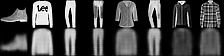

313/313 [==============================] - 1s 2ms/step


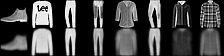

313/313 [==============================] - 1s 2ms/step


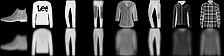

313/313 [==============================] - 1s 2ms/step


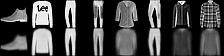

313/313 [==============================] - 1s 2ms/step


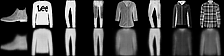

313/313 [==============================] - 1s 2ms/step


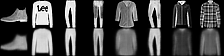

313/313 [==============================] - 1s 2ms/step


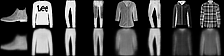

313/313 [==============================] - 1s 2ms/step


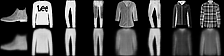

313/313 [==============================] - 1s 2ms/step


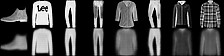

313/313 [==============================] - 1s 2ms/step


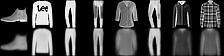

313/313 [==============================] - 1s 2ms/step


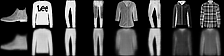

313/313 [==============================] - 1s 2ms/step


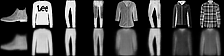

313/313 [==============================] - 1s 2ms/step


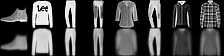

313/313 [==============================] - 1s 2ms/step


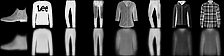

313/313 [==============================] - 1s 2ms/step


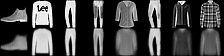

313/313 [==============================] - 1s 2ms/step


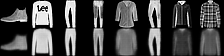

313/313 [==============================] - 1s 3ms/step


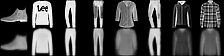

313/313 [==============================] - 1s 2ms/step


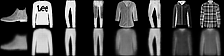

313/313 [==============================] - 1s 3ms/step


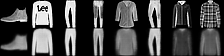

313/313 [==============================] - 1s 2ms/step


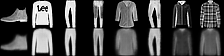

313/313 [==============================] - 1s 2ms/step


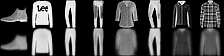

In [60]:
if not os.path.exists('compare'):
    os.mkdir('compare')

trainAccList = []
testAccList = []
trainLossList = []

for i in range(epochs):
  history = vae.fit(trainImage,
      shuffle=True,
      epochs=1,
      batchSize=batchSize,
      validation_data=(testImage, None))

  trainLossList.append(history.history['loss'][0])

  trainImageEncoded = encoder.predict(trainImage)
  trainLabelPred = classifier.predict(trainImageEncoded).argmax(axis=1)
  testImageEncoded = encoder.predict(testImage)
  testLabelPred = classifier.predict(testImageEncoded).argmax(axis=1)
  right = 0.
  for j in range(10):
    _ = np.bincount(trainLabel[trainLabelPred == j])
    right += _.max()

  trainAccList.append(right / len(trainLabel))

  right = 0.
  for j in range(10):
    _ = np.bincount(testLabel[testLabelPred == j])
    right += _.max()

  testAccList.append(right / len(trainLabel))

  if (i + 1) % 10 == 0 or i == 0:
    reconstruction = decoder.predict(testImageEncoded)
    n = 8
    fig = np.zeros((imgShape * 2, imgShape * n))
    for m in range(n):
      testImageOrigin = testImage[m].reshape((imgShape, imgShape))
      fig[0 * imgShape: (0 + 1) * imgShape,
             m * imgShape: (m + 1) * imgShape] = testImageOrigin

      testImageGenerate = reconstruction[m].reshape((imgShape, imgShape))
      fig[1 * imgShape: (1 + 1) * imgShape,
             m * imgShape: (m + 1) * imgShape] = testImageGenerate

      fit_path = './compare/epoch' + str(i + 1) + '_compare.png'
      imageio.imwrite(fit_path, fig * 255)

    fig_pil = Image.fromarray((fig * 255).astype(np.uint8))

    display(fig_pil)

vae.save(vaeFileName)
encoder.save(encoderFileName)
decoder.save(decoderFileName)
classifier.save(classifierFileName)

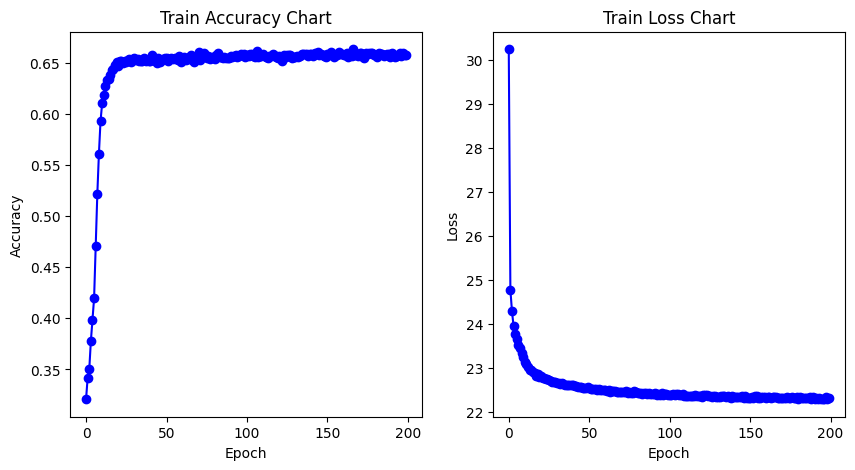

In [74]:
def plot_line_chart(data_list1, data_list2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].plot(range(len(data_list1)), data_list1, marker='o', linestyle='-', color='b')
    axes[0].set_title('Train Accuracy Chart')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')

    axes[1].plot(range(len(data_list2)), data_list2, marker='o', linestyle='-', color='b')
    axes[1].set_title('Train Loss Chart')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')

    plt.savefig('./chart.png')

plot_line_chart(trainAccList, trainLossList)

In [64]:
custom_objects = {'Gaussian': Gaussian}

vae = load_model(vaeFileName, custom_objects=custom_objects)
encoder = load_model(encoderFileName)
decoder = load_model(decoderFileName)
classifier = load_model(classifierFileName)

In [65]:
means = K.eval(gaussian.mean)
trainImageEncoded = encoder.predict(trainImage)
trainLabelPred = classifier.predict(trainImageEncoded).argmax(axis=1)
testImageEncoded = encoder.predict(testImage)
testLabelPred = classifier.predict(testImageEncoded).argmax(axis=1)

313/313 [==============================] - 0s 1ms/step


In [66]:
def ClusterSample(path, label=0):
    n = 8
    figure = np.zeros((imgShape * n, imgShape * n))
    idxs = np.where(trainLabelPred == label)[0]
    for i in range(n):
        for j in range(n):
            digit = trainImage[np.random.choice(idxs)]
            digit = digit.reshape((imgShape, imgShape))
            figure[i * imgShape: (i + 1) * imgShape,
            j * imgShape: (j + 1) * imgShape] = digit
    imageio.imwrite(path, figure * 255)

In [67]:
def RandomSample(path, label=0, std=1):
    n = 8
    figure = np.zeros((imgShape * n, imgShape * n))
    for i in range(n):
        for j in range(n):
            noise_shape = (1, latentDim)
            z_sample = np.array(np.random.randn(*noise_shape)) * std + means[label]
            xReconstruction = decoder.predict(z_sample)
            digit = xReconstruction[0].reshape((imgShape, imgShape))
            figure[i * imgShape: (i + 1) * imgShape,
            j * imgShape: (j + 1) * imgShape] = digit
    imageio.imwrite(path, figure * 255)

In [75]:
if not os.path.exists('results'):
    os.mkdir('results')

for i in range(10):
    ClusterSample(u'results/ClusteringResult_%s.png' % i, i)
    RandomSample(u'results/SamplingResult_%s.png' % i, i)

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 29ms/step


In [68]:
right = 0.
for i in range(10):
    _ = np.bincount(trainLabel[trainLabelPred == i])
    right += _.max()

print (f'train acc: {right / len(trainLabel)}')


right = 0.
for i in range(10):
    _ = np.bincount(testLabel[testLabelPred == i])
    right += _.max()

print (f'test acc: {right / len(testLabel)}')

train acc: 0.6576
test acc: 0.6546
